<h1> Final Project - ASTRO 598 </h1> <h2> Daniela Koch - Fall 2019 </h2>


In this |project I will be building two neural networks (one regular, one deep) to investigate asymmetries in protein distribution after cell division in E. Coli cells. Different types of protein are distributed differently within the cell throughout the cell cycle - some are fairly unifiomly distributed while some exhibit a time dependent structure. The location and dynamics of these proteins are crucial to cellular function are not yet well understood on cellular scale.

We are hoping to use neural networks to classify protein dynamics, and to start I will be building a network and training it to distinguish between just two protein patterns. 


<h4> The Data </h4>
The data set collected previously by our lab is publicly available at http://mtshasta.phys.washington.edu/aska2/html/gene.html. The data files are in MATLAB and contain substantially more information than is relevant to the scope of this project. The data I use in this project has been cleaned and converted into csv files containing only the relevant information. This process took place in MATLAB and is therefore not included in this notebook, but the relevant information used in this process can be found at https://github.com/wiggins-lab/SuperSegger/wiki/The-cell-data-files

(Note: this process took substantially longer than anticipated so I don't have as much data as I would like, but this project serves as a good proof of concept)



I will build supervised neural network to classify cell images based on protein labels. 
For now, I will be distinguishing between only two different proteins - yahE and minD.

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=0.8, 
        context="paper", 
        style="ticks", 
        rc={"axes.linewidth": 0.8})
sns.set_palette("Set2", 3)

%matplotlib inline

C:\Users\12mik\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h5> Import the Data</h5>

My data set for this part of the project is comprised of 925 images of yahE and 1432 images of minD. 

The inital images have significant cell-to-cell variation in size and orientation, making them unsuitable inputs for a neural network which (generally) requires that all inputs be the same dimension. (Note: I did some research on creating a neural network that takes in variable input sizes, but successfully implementing such a network would have taken longer than this project permits).

The data sets uploaded here have been cleaned up such that all images have the same dimensions (78x92 pixels) and the same cell orientation (principal axis along x-axis).
 

In [2]:
yahE = np.loadtxt('reshape_yahE.csv',delimiter=",")
minD = np.loadtxt('reshape_minD.csv',delimiter=",")

My data is originally in MATLAB (.mat) files. By converting them to .csv files, they were flattened into just one large image, so I need to reshape my arrays to separate the images. 

<h5> Convert the data into an array</h5>

In [3]:
yahE_im=[]
niko=91
for i in range(925):
    yahE_im.append(np.array(yahE[:, niko-91:niko+1]))
    niko+=92
       
    
minD_im=[]
yzma=91
for i in range(925):
    minD_im.append(np.array(minD[:, yzma-91:yzma+1]))
    yzma+=92
    



In [4]:
minD_im[1].shape

(78, 92)

Let's take a look at a sample image of  each protein: its a little difficult to see, but he the minD shows greater fluorescence towards the left hand side of the cell, whereas the yahE appears fairly uniform throughout the cell. 

<h4> Plot a sample of the data</h4>

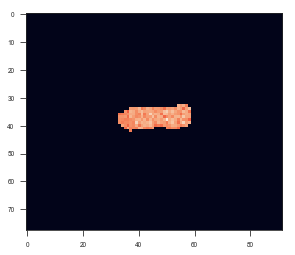

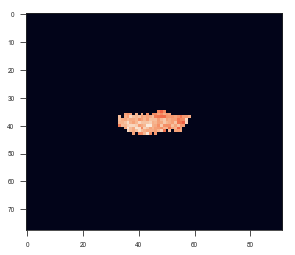

In [5]:
plt.figure(1)
plt.imshow(yahE_im[10])

plt.figure(2)
plt.imshow(minD_im[10])

Now we have to divide our data into training and test data. We will take 800 from each type of cell for a total training set of 1600 samples

In [6]:
yahE_train=yahE_im[0:800]
minD_train=minD_im[0:800]

yahE_test=yahE_im[800:925]
minD_test=minD_im[800:925]

I want to combine these two training sets into one list. Rather than just appending one to the end of the other, I will combine them to alternate between yahE and minD. This is so that when we train the network, we don't overfit for yahE before introducing minD. The following is a demonstration of how I will combine the sets

In [7]:
list1=[0,0,0,0]
list2=[1,1,1,1]


def countList(lst1, lst2): 
    return [sub[item] for item in range(len(lst2)) 
                    for sub in [lst1, lst2]] 

print(countList(list1,list2))

[0, 1, 0, 1, 0, 1, 0, 1]


Use this function to combine the lists

In [8]:
training_data=np.array(countList(yahE_train,minD_train))

#make sure its the same length
print(len(training_data))


1600


For the sake of our network, we need to assign values to our 'labels' and make an array. Then we will use LabelEncoder to assign numerical values to the labels

In [9]:
yahE_label=0
minD_label=1

labels=[0, 1]

label_array=np.array(labels*800)
#this is now a list comprised of 1600 elements matching those in the training data (ie they alternate)

from keras.utils import np_utils

num_classes=2
# One-hot encoding
training_labels = np_utils.to_categorical(label_array, num_classes)



Using TensorFlow backend.


Now we have to do the same thing for the training data - but it doesn't matter what order the test data is in so we will just append them

In [10]:
test_data_list=yahE_test+minD_test

test_data= np.array(test_data_list)


zeros=[0]*125
ones=[1]*125
test_label_array=np.array(zeros+ones)

#make sure they are the same length

test_labels = np_utils.to_categorical(test_label_array, num_classes)


len(test_data_list)


250

<h4> Crop the images</h4>

In [11]:
#Crop the images to make smaller using format x[start1:end1, start2:end2, start3:end3]

training_data_crop=training_data[0:1600, 30:50 ,20:70]
test_data_crop=test_data[0:250, 30:50, 20:70]

test_data_crop.shape

(250, 20, 50)

In [12]:
training_data_reshape=np.reshape(training_data_crop,(1600,1000))


#have to flatten the images

test_data_reshape=np.reshape(test_data_crop,(250,1000))
test_data_reshape.shape


(250, 1000)

<h3> Plot the Data</h3>


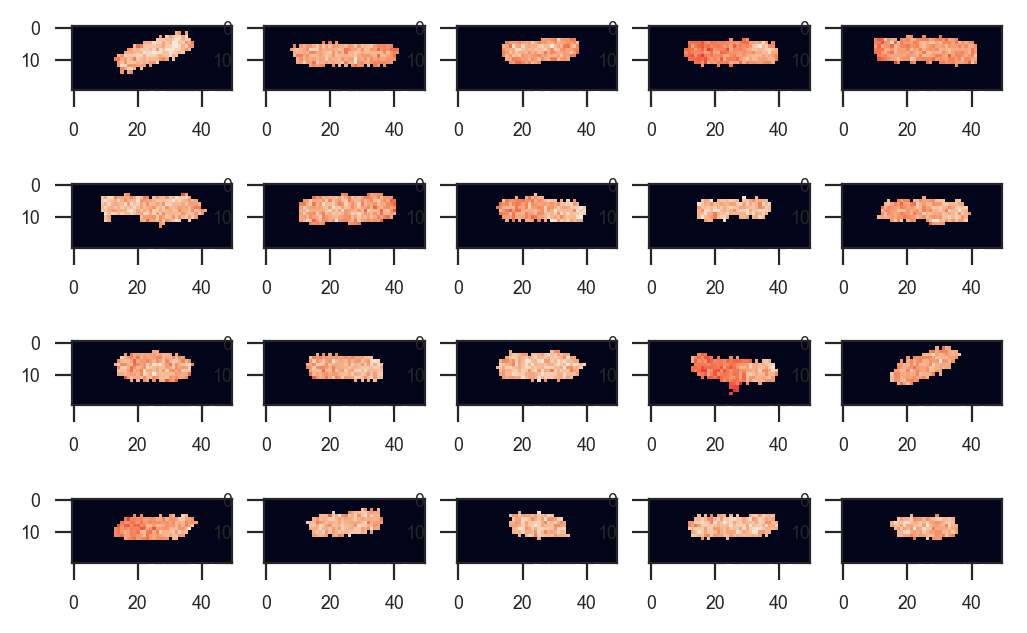

In [13]:
num_samples = 20 # multiple of 5
num_train_samples=1600
selection = np.random.choice(np.arange(0, num_train_samples), 
                             size=num_samples,
                             replace=False)



fig, ax = plt.subplots(int(num_samples/5), 5, dpi=200)
for i, (a, s) in enumerate(zip(ax.ravel(), selection)):
    a.imshow(training_data_crop[i, :, :])
    a.text(23, 26, training_labels[s], color="w")
 


<h2> Building the Neural Network</h2>

In [20]:
num_classes=2
num_rows=20
num_cols=50


from keras.models import Sequential
from keras.layers import Dense # A fully connected layer

BATCH_SIZE = 10# The number of samples to run through the network before the weights / gradient are updated
EPOCHS = 5 # The number of times to iterate through the complete sample of training data 

model = Sequential()
model.add(Dense(num_classes, 
                activation="softmax", # See: https://keras.io/activations/
                input_shape=(num_rows * num_cols,))) 

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='categorical_crossentropy', # See: https://keras.io/losses/
              optimizer='rmsprop', # See: https://keras.io/optimizers/
              metrics=['accuracy'])

Next, we train the model on training data, validate on test data

In [23]:
score = model.evaluate(test_data_reshape, test_labels, 
                       batch_size=BATCH_SIZE, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

250/250 [==============================] - 0s 447us/step
Test loss: 5.496908099918546
Test accuracy: 0.6160000014305115


In [24]:
history = model.fit(training_data_reshape, training_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(test_data_reshape, test_labels))

Train on 1600 samples, validate on 250 samples
Epoch 1/5
1600/1600 [==============================] - 0s 300us/step - loss: 4.3506 - acc: 0.7088 - val_loss: 3.4245 - val_acc: 0.7720
Epoch 2/5
1600/1600 [==============================] - 0s 275us/step - loss: 3.2588 - acc: 0.7825 - val_loss: 4.4053 - val_acc: 0.7040
Epoch 3/5
1600/1600 [==============================] - 0s 232us/step - loss: 3.0631 - acc: 0.8006 - val_loss: 2.5741 - val_acc: 0.8320
Epoch 4/5
1600/1600 [==============================] - 0s 269us/step - loss: 2.6822 - acc: 0.8250 - val_loss: 2.7468 - val_acc: 0.8200
Epoch 5/5
1600/1600 [==============================] - 0s 222us/step - loss: 2.4694 - acc: 0.8387 - val_loss: 2.4241 - val_acc: 0.8440


<h2> Deep Neural Net </h2>

Now we are going to see if we can improve the accuracy of our network by adding more fully connected layers

In [26]:
BATCH_SIZE = 10 
EPOCHS = 5 

model = Sequential()
model.add(Dense(32, 
                activation="relu",
                input_shape=(num_rows * num_cols,)))
model.add(Dense(num_classes, 
                activation="softmax"))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(training_data_reshape, training_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(test_data_reshape, test_labels))

score = model.evaluate(test_data_reshape, test_labels, 
                       batch_size=BATCH_SIZE, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                32032     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 32,098
Trainable params: 32,098
Non-trainable params: 0
_________________________________________________________________
Train on 1600 samples, validate on 250 samples
Epoch 1/5
1600/1600 [==============================] - 1s 405us/step - loss: 5.8378 - acc: 0.6263 - val_loss: 4.5972 - val_acc: 0.7080
Epoch 2/5
1600/1600 [==============================] - 0s 260us/step - loss: 3.4154 - acc: 0.7769 - val_loss: 3.4729 - val_acc: 0.7760
Epoch 3/5
1600/1600 [==============================] - 0s 255us/step - loss: 3.2850 - acc: 0.7900 - val_loss: 4.4614 - val_acc: 0.7200
Epoch 4/5
1600/1600 [==============================] - 0s 250us/step - loss: 3.492

The test accuracy got better! Yay!

I will be continuing this work in my research - adding more data and different kinds of proteins and playing with the number of layers and nodes to emperically optimize the test accuracy. 